In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm


In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.gratings.utils as gutils
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Plotting params

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'


# Load data

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,15,15,15
V1,18,18,18


In [388]:
response_type='dff'
do_spherical_correction=True
# ---------------------------------------------------------------
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
data_id = '%s_%s' % (traceid, rf_fit_desc)
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                       '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

rf_str = 'sphr_corrected' if do_spherical_correction else ''
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 
                      'single_cell_aggregate', 'receptive_fields', rf_str)
print(FIGDIR)
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

traces001_fit-2dgaus_dff_sphr
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/single_cell_aggregate/receptive_fields/sphr_corrected


In [389]:
# Load RF fit params for good rois
# rfdata = rfutils.cycle_and_load(rf_meta, CELLS, reliable_only=True, 
#                         fit_desc=rf_fit_desc, traceid=traceid, verbose=False)
rfdata = rfutils.aggregate_rfdata(meta, CELLS, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Get ROI positions
rfdata = aggr.add_roi_positions(rfdata)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [390]:
# Get cell counts for all cells
all_cell_counts = rfdata.groupby(['visual_area', 'datakey', 'experiment'])['cell']\
                    .count().reset_index()
print(all_cell_counts.groupby(['visual_area', 'experiment']).sum())

                        cell
visual_area experiment      
Li          rfs           56
            rfs10        491
Lm          rfs          349
            rfs10         48
V1          rfs          631
            rfs10        558


In [391]:
# Save counts
counts_outfile = os.path.join(dst_dir, 'all_cell_counts.csv')
all_cell_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/all_cell_counts.csv


# Average N cells per

In [392]:
rfdf_combined = rfutils.average_rfs(rfdata, keep_experiment=False)

In [393]:
combined_counts = aggr.count_n_cells(rfdf_combined, name='cell')

In [394]:
min_ncells=5
pass_counts = combined_counts[combined_counts.cell>=min_ncells]


In [395]:
u_dkeys = aggr.drop_repeats(pass_counts.copy())

In [396]:
combined_u = pd.concat([rfdf_combined[(rfdf_combined.visual_area==va)
                                     & (rfdf_combined.datakey==dk)] \
                        for (va, dk) in u_dkeys])


In [397]:
combined_u_counts = aggr.count_n_cells(combined_u, name='n_fit')

In [398]:
NDATA0 = aggr.load_responsive_neuraldata('rfs', traceid=traceid,
                      response_type=response_type, trial_epoch='stimulus',
                      responsive_test='nstds', responsive_thr=7.0)
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl


In [399]:
resp_cells = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()

In [400]:
# merged = pd.merge(resp_cells, combined_u, on=['visual_area','datakey', 'cell'], how='inner')
fit_cells = pd.concat([combined_u[(combined_u.visual_area==va)
                                 & (combined_u.datakey==dk)
                                 & (combined_u.cell.isin(g['cell'].unique()))]\
                      for (va, dk), g \
                       in resp_cells.groupby(['visual_area', 'datakey'])])

In [401]:
responsive_counts = aggr.count_n_cells(NDATA, name='n_responsive')
fit_counts = aggr.count_n_cells(fit_cells, name='n_fit')

In [402]:
responsive_counts.shape, fit_counts.shape

((28, 3), (28, 3))

In [403]:
counts = pd.merge(responsive_counts, fit_counts, on=['visual_area', 'datakey'])
counts['fraction_fit'] = counts['n_fit']/counts['n_responsive']

<IPython.core.display.Javascript object>


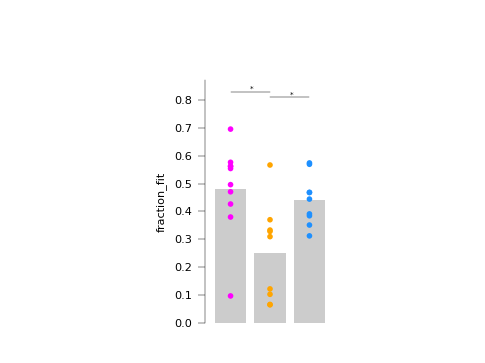

[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, '')]

In [405]:

fig, ax = pl.subplots(figsize=(4,3),dpi=150)


pplot.stripplot_metric_by_area(counts, ax=ax, metric='fraction_fit', markersize=3,
                        area_colors=area_colors, posthoc='fdr_bh',
                        y_loc=0.8+0.01, offset=0.01, #ylim=(0, 1.03),
                        aspect=2, sig_fontsize=4, jitter=False,
                        return_stats=True, plot_means=True,
                        mean_style='bar', mean_type='mean'   )
ax.set_xticklabels('')

## Compare rf-5 / rf-10

In [653]:
#### Current output dir
curr_subdir = 'rfs5_v_rfs10'
curr_dst_dir = os.path.join(dst_dir, curr_subdir)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
if not os.path.exists(os.path.join(FIGDIR, curr_subdir)):
    os.makedirs(os.path.join(FIGDIR, curr_subdir))

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10


In [654]:
counts = rfdata.groupby(['visual_area', 'animalid', 'datakey', 'experiment'])['cell']\
            .count().reset_index()
print(counts.groupby(['visual_area', 'experiment']).sum())

                        cell
visual_area experiment      
Li          rfs           56
            rfs10        491
Lm          rfs          349
            rfs10         48
V1          rfs          631
            rfs10        558


<IPython.core.display.Javascript object>


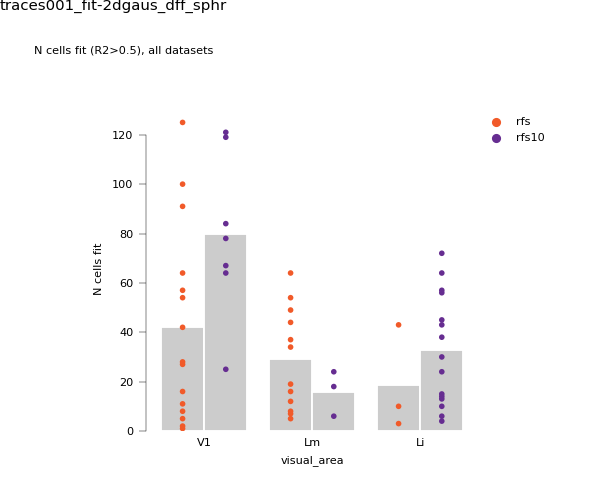

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10


In [655]:
rf_colors={'rfs': '#f15a29', 'rfs10': '#662d91'}
rf_sizes = ['rfs', 'rfs10']

fig, ax = pl.subplots(figsize=(5,4), dpi=150)
sns.stripplot(x='visual_area', y='cell', data=counts,ax=ax,
             hue='experiment', hue_order=rf_sizes, dodge=True, size=3,
             order=visual_areas, palette=rf_colors, alpha=1, jitter=False)
sns.barplot(x='visual_area', y='cell', data=counts,ax=ax,
             hue='experiment', hue_order=rf_sizes, dodge=True, 
            order=visual_areas,
             palette=dict((k, [0.8]*3) for k in rf_sizes), ci=None, edgecolor='w')
ax.set_ylabel('N cells fit')
ax.set_box_aspect(1)
pplot.crop_legend_labels(ax, 2, start_ix=0,markerscale=0.5 ,
                         bbox_to_anchor=(1,1), loc='upper left', fontsize=6)
pplot.label_figure(fig, data_id)
fig.text(0.05, 0.9, "N cells fit (R2>0.5), all datasets")
sns.despine(bottom=True, offset=2, trim=True)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(bottom=0.2, right=0.8, top=0.8)

pl.savefig(os.path.join(curr_dst_dir, 'counts_by_fov.svg'))
print(curr_dst_dir)
pl.savefig(os.path.join(FIGDIR, curr_subdir, 'counts_by_fov.svg'))


In [656]:
cells_w_both = pd.concat([g for (va, dk, ri), g in \
                rfdata.groupby(['visual_area', 'datakey', 'cell']) \
                if 'rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values])
cells_w_both.groupby(['experiment', 'visual_area']).count()

x0   y0  fwhm_x  fwhm_y  theta  offset  amplitude  \
experiment visual_area                                                       
rfs        Li            40   40      40      40     40      40         40   
           Lm             7    7       7       7      7       7          7   
           V1           186  186     186     186    186     186        186   
rfs10      Li            40   40      40      40     40      40         40   
           Lm             7    7       7       7      7       7          7   
           V1           186  186     186     186    186     186        186   

                         r2  std_x  std_y  ...  datakey  animalid  fov  \
experiment visual_area                     ...                           
rfs        Li            40     40     40  ...       40        40   40   
           Lm             7      7      7  ...        7         7    7   
           V1           186    186    186  ...      186       186  186   
rfs10      Li            40     40     40  ...       40        40   40   
           Lm             7      7      7  ...        7         7    7   
           V1           186    186    186  ...      186       186  186   

                        session  fov_xpos  fov_xpos_pix  fov_ypos  \
experiment visual_area                                              
rfs        Li                40        40            40        40   
           Lm                 7         7             7         7   
           V1               186       186           186       186   
rfs10      Li                40        40            40        40   
           Lm                 7         7             7         7   
           V1               186       186           186       186   

                        fov_ypos_pix  ml_pos  ap_pos  
experiment visual_area                                
rfs        Li                     40      40      40  
           Lm                      7       7       7  
           V1                    186     186     186  
rfs10      Li                     40      40      40  
           Lm                      7       7       7  
           V1                    186     186     186  

[6 rows x 38 columns]

In [657]:
cells_w_both.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy',
       'theta_c', 'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy',
       'theta_Mm_c', 'aniso_index', 'eccentricity', 'eccentricity_ctr',
       'rf_theta_deg', 'aspect_ratio', 'cell', 'datakey', 'visual_area',
       'experiment', 'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix',
       'fov_ypos', 'fov_ypos_pix', 'ml_pos', 'ap_pos'],
      dtype='object')

#### Correlation of metrics for rf-5 v rf-10

<IPython.core.display.Javascript object>


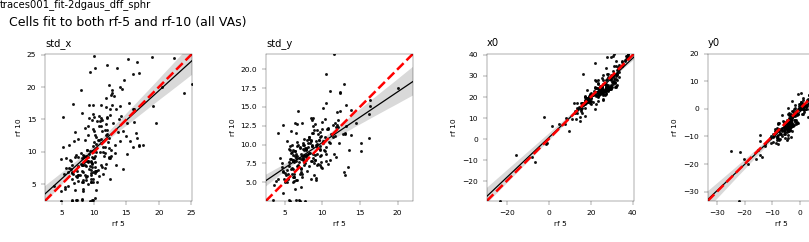

Wilcoxon paired test:
... param: std_y (p=0.00)
... param: x0 (p=0.00)
... param: y0 (p=0.00)
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10 allparams__cells_w_both


In [658]:
params_to_check = ['std_x', 'std_y', 'x0', 'y0'] #, 'aniso_index']
fig, axn = pl.subplots(1, len(params_to_check), figsize=(10,3))
print("Wilcoxon paired test:")
for pi, par in enumerate(params_to_check):
    ax = axn[pi]
    ax.set_title(par,loc='left')
    v1 = cells_w_both[cells_w_both.experiment=='rfs'][par].values
    v2 = cells_w_both[cells_w_both.experiment=='rfs10'][par].values
    vmin = min([np.min(v1), np.min(v2)])
    vmax = max([np.max(v1), np.max(v2)])
    ax.set_ylim([vmin, vmax]); ax.set_xlim([vmin, vmax]);
    ax.set_aspect('equal')
    sns.regplot(x=v1, y=v2, ax=ax, color='k', truncate=False,
                scatter_kws={'s':2}, line_kws={'lw': 1})
    ax.set_xlabel('rf 5'); ax.set_ylabel('rf 10');
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=2)
    ax.set_box_aspect(1)
    # Annotate w stats
    stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
    if p<0.05:
        print("... param: %s (p=%.2f)" % (par, p))
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9, wspace=0.5, hspace=0.5)    
fig.text(0.01, 0.9, 'Cells fit to both rf-5 and rf-10 (all VAs)', fontsize=10)

pplot.label_figure(fig, data_id)
figname = 'allparams__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Split by VA

<IPython.core.display.Javascript object>


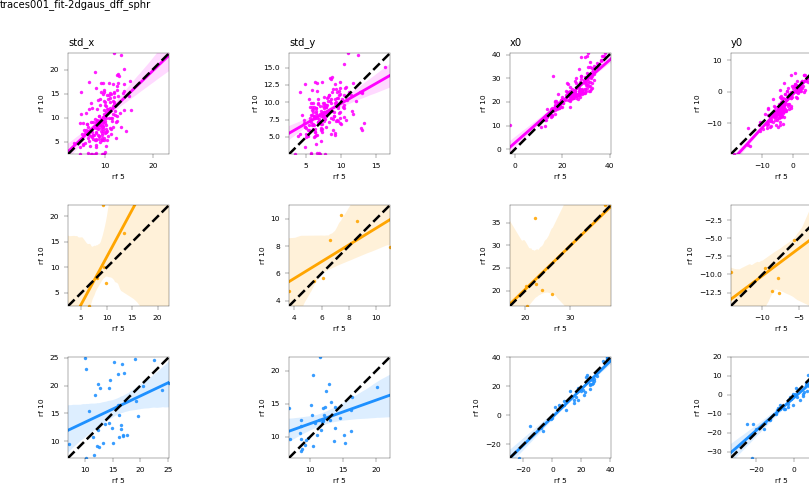

...[V1] param: std_y (p=0.00)
...[Li] param: x0 (p=0.01)
...[V1] param: x0 (p=0.00)
...[Li] param: y0 (p=0.03)
...[V1] param: y0 (p=0.00)
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10 allparams_byVA__cells_w_both


In [659]:
#params_to_check = ['std_x', 'std_y', 'x0', 'y0', 'anisotropy', 'aniso_index']
params_to_check = ['std_x', 'std_y', 'x0', 'y0'] #, 'aniso_index']
fig, axn = pl.subplots(3, len(params_to_check), figsize=(10,6))
for pi, par in enumerate(params_to_check):
    for va, vg in cells_w_both.groupby(['visual_area']):
        vi = visual_areas.index(va)
        ax = axn[vi, pi]
        if vi==0:
            ax.set_title(par,loc='left')
        v1 = vg[vg.experiment=='rfs'][par].values
        v2 = vg[vg.experiment=='rfs10'][par].values
        vmin = min([np.min(v1), np.min(v2)])
        vmax = max([np.max(v1), np.max(v2)])
        ax.set_ylim([vmin, vmax]); ax.set_xlim([vmin, vmax]);
        ax.set_aspect('equal')
        #ax.scatter(v1, v2, s=5, color=area_colors[va])
        sns.regplot(x=v1, y=v2, ax=ax, color=area_colors[va], truncate=False,
                    scatter_kws={'s':3})
        ax.set_xlabel('rf 5'); ax.set_ylabel('rf 10');
        ax.plot([vmin, vmax], [vmin, vmax], 'k--', lw=2)
        # Annotate w stats
        stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
        if p<0.05:
            print("...[%s] param: %s (p=%.2f)" % (va, par, p))
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9, wspace=0.5, hspace=0.5)
pplot.label_figure(fig, data_id)

figname = 'allparams_byVA__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


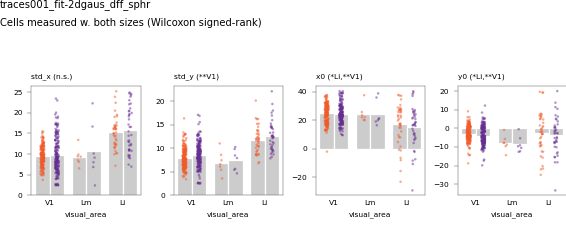

[std_x] ----------------------
[std_y] ----------------------
[x0] ----------------------
[y0] ----------------------
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10 comparestimsize__cells_w_both


In [660]:
fontsize=6
point_size=2
#params_to_check = ['std_x', 'std_y', 'fx', 'fy','x0', 'y0', 'anisotropy', 'aniso_index', 'theta'] # 'theta'] #, 'theta_Mm_deg']
params_to_check = ['std_x', 'std_y', 'x0', 'y0'] #, 'aniso_index']
fig, axn = pl.subplots(1, len(params_to_check), 
                       figsize=(7,3), sharex=True, sharey=False)
fig.patch.set_alpha(1)
for ai, metric in enumerate(params_to_check):
    print("[%s] ----------------------" % metric)
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=cells_w_both,ax=ax,
                 hue='experiment',  dodge=0.5, order=visual_areas, s=2, zorder=-1, 
                 palette=rf_colors, alpha=0.5)
    sns.barplot(x='visual_area', y=metric, data=cells_w_both, ax=ax,
                  estimator=spstats.circmean if 'theta' in metric else np.mean,
                  hue='experiment', palette=dict((k, [0.8]*3) for k in rf_sizes),
                  dodge=0.5, order=visual_areas, ci=None, zorder=-10000,
               edgecolor='w')
#     sns.pointplot(x='visual_area', y=metric, data=cells_w_both,
#                   estimator=spstats.circmean if 'theta' in metric else np.mean,
#                  hue='experiment', ax=ax, dodge=0.5, join=False,
#                   order=visual_areas, ci=95, zorder=-1, color='k',
#                   markers='_', scale=1, errwidth=1)
    # Annotate w stats
    info_str=[]
    for va, vg in cells_w_both.groupby(['visual_area']):
        v1 = vg[vg.experiment=='rfs'][metric].values
        v2 = vg[vg.experiment=='rfs10'][metric].values
        stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
        if round(p, 2)<0.05:
            info_str.append('**%s' % va if p<0.01 else '*%s' % va)
    title_str = '%s (%s)' % (metric, ','.join(info_str)) \
                        if len(info_str)>0 else '%s (n.s.)' % metric
    ax.set_title(title_str, loc='left', fontsize=fontsize)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_ylabel('')
    ax.legend_.remove()
    ax.set_box_aspect(1)
ax=axn[-1]
pplot.crop_legend_labels(ax, 2, start_ix=0,markerscale=0.5 ,
                         bbox_to_anchor=(1,1), loc='upper left', fontsize=6)
pl.subplots_adjust(top=0.75, bottom=0.2, left=0.05, right=0.9, wspace=0.3, hspace=0.5)
fig.text(0.0, 0.9, 'Cells measured w. both sizes (Wilcoxon signed-rank)', fontsize=8)
pplot.label_figure(fig, data_id)

figname = 'comparestimsize__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(FIGDIR, curr_subdir, '%s.svg' % figname))


In [661]:
for par in ['std_avg', 'aspect_ratio']:
    print('%s------------------------' % par)
    print(cells_w_both.groupby(['visual_area', 'experiment'])[par].describe().round(2))

std_avg------------------------
                        count   mean   std   min    25%    50%    75%    max
visual_area experiment                                                      
Li          rfs          40.0  13.49  2.64  7.93  11.06  13.78  14.99  19.48
            rfs10        40.0  14.25  3.25  8.14  11.66  13.98  17.22  19.58
Lm          rfs           7.0   8.15  2.07  5.07   7.03   8.03   9.44  11.02
            rfs10         7.0   9.13  4.30  3.55   7.06   7.39  11.28  16.27
V1          rfs         186.0   8.71  1.82  4.37   7.54   8.54   9.89  14.79
            rfs10       186.0   9.17  2.80  3.75   7.30   8.76  11.13  19.92
aspect_ratio------------------------
                        count  mean   std   min   25%   50%   75%   max
visual_area experiment                                                 
Li          rfs          40.0  1.44  0.25  1.08  1.24  1.38  1.59  2.04
            rfs10        40.0  1.54  0.29  1.10  1.30  1.53  1.68  2.21
Lm          rfs           7

In [662]:
cells_w_both

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,1.569643,19.600794,23.409428,28.074691,0.231200,0.001541,0.089544,0.521575,9.961459,11.946677,...,rfs,JC089,FOV1_zoom2p0x,20190522,467.813699,203.0,801.465362,421.0,171.334638,709.786301
3,6.076728,20.027911,58.486419,29.569804,3.792287,-0.001732,0.069600,0.569381,24.887838,12.582895,...,rfs10,JC089,FOV1_zoom2p0x,20190522,467.813699,203.0,801.465362,421.0,171.334638,709.786301
2,15.955229,5.266964,56.078174,30.760939,6.014498,-0.004701,0.052110,0.511608,23.863053,13.089761,...,rfs,JC089,FOV1_zoom2p0x,20190522,910.277886,395.0,757.679843,398.0,215.120157,267.322114
8,12.590894,1.505710,44.937382,29.332320,0.329375,-0.006463,0.070388,0.564083,19.122290,12.481838,...,rfs10,JC089,FOV1_zoom2p0x,20190522,910.277886,395.0,757.679843,398.0,215.120157,267.322114
68,27.280223,-7.525923,29.000612,25.261052,0.270594,-0.004942,0.172701,0.711023,12.340686,10.749384,...,rfs,JC091,FOV1_zoom2p0x,20190602,168.228571,73.0,493.063014,259.0,479.736986,1009.371429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,24.584920,0.103789,15.416762,5.970009,6.180329,-0.002697,0.499425,0.710138,6.560324,2.540429,...,rfs10,JC110,FOV1_zoom2p0x,20191006,820.402348,356.0,521.618787,274.0,451.181213,357.197652
2036,29.802425,-1.500708,36.035798,21.706459,0.500881,-0.005827,0.075014,0.711567,15.334382,9.236791,...,rfs,JC110,FOV1_zoom2p0x,20191006,838.838356,364.0,348.380431,183.0,624.419569,338.761644
2101,38.906450,-0.743590,41.280520,27.916996,0.181532,-0.003590,0.064776,0.651594,17.566179,11.879573,...,rfs10,JC110,FOV1_zoom2p0x,20191006,838.838356,364.0,348.380431,183.0,624.419569,338.761644
2040,19.338377,-0.078987,30.297792,15.392387,0.104588,-0.004761,0.069606,0.529228,12.892678,6.549952,...,rfs,JC110,FOV1_zoom2p0x,20191006,410.201174,178.0,708.183170,372.0,264.616830,767.398826


<IPython.core.display.Javascript object>


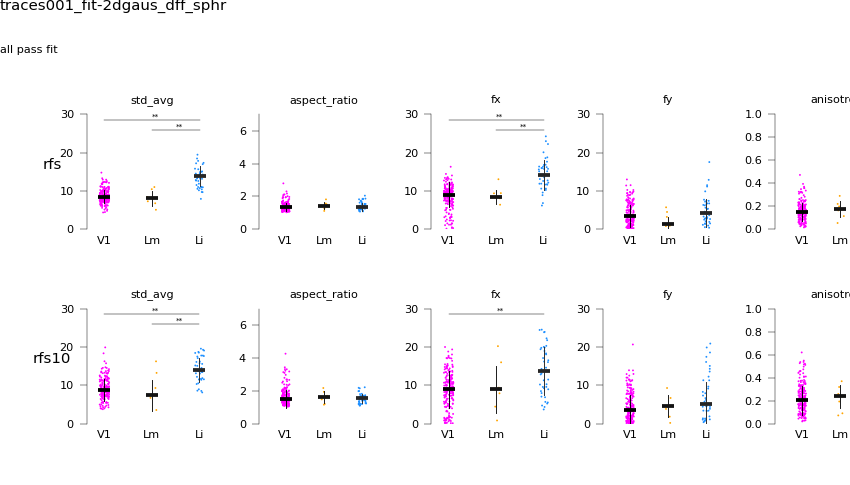

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10 size_metrics_cells-w-both__byCELL


In [673]:
%matplotlib notebook
plot_str='byCELL'
offset=1
plot_metrics = ['std_avg', 'aspect_ratio', 'fx', 'fy', 'anisotropy']
multi_comp_test='fdr_bh'
markersize=1
mean_type='median'
ylim = (0, 30)
fig, axn = pl.subplots(2, len(plot_metrics),
                       figsize=(7,4), sharey=False, dpi=150)
for ai, metric in enumerate(plot_metrics):
    if metric=='aspect_ratio':
        ylim = (0, 7)
        y_loc=5
    elif metric=='anisotropy':
        ylim = (0, 1)
        y_loc=0.9
    else:
        y_loc=26
        ylim = (0, 30)
    for ri, (rfsize, df_) in enumerate(cells_w_both.groupby(['experiment'])):
        ax=axn[ri, ai]
        pplot.stripplot_metric_by_area(df_, metric, area_colors=area_colors,
                                markersize=1, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, 
                                plot_means=True, y_loc=y_loc, offset=y_loc/10.,
                                mean_style='point', mean_type=mean_type, 
                                aspect=1., axis_offset=4)
        #ax.set_ylabel('deg. visual angle')
        ax.set_title(metric, fontsize=fontsize)
        if ai==0:
            ax.set_ylabel(rfsize, fontsize=8, rotation=0)
        else:
            ax.set_ylabel('')
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)
pplot.label_figure(fig, data_id)

fig.text(0, 0.9, 'Aggregate metrics, combined rfs (%s)' \
         % reliable_str if reliable_only else 'all pass fit')
figname = 'size_metrics_cells-w-both_%s_%s' % (reliable_str, plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [693]:
all_rf_counts

,visual_area,datakey,n_cells,animalid,fov,session
0,Li,20190522_JC089_fov1,7,JC089,FOV1_zoom2p0x,20190522
1,Li,20190527_JC092_fov3,45,JC092,FOV3_zoom2p0x,20190527
2,Li,20190528_JC092_fov1,13,JC092,FOV1_zoom2p0x,20190528
3,Li,20190602_JC091_fov1,74,JC091,FOV1_zoom2p0x,20190602
4,Li,20190606_JC091_fov1,38,JC091,FOV1_zoom2p0x,20190606
5,Li,20190607_JC091_fov1,57,JC091,FOV1_zoom2p0x,20190607
6,Li,20190609_JC099_fov1,43,JC099,FOV1_zoom2p0x,20190609
7,Li,20190612_JC099_fov1,56,JC099,FOV1_zoom2p0x,20190612
8,Li,20190614_JC091_fov1,72,JC091,FOV1_zoom2p0x,20190614
9,Li,20190617_JC099_fov1,14,JC099,FOV1_zoom2p0x,20190617


In [717]:
all_rf_counts = aggr.count_n_cells(rfdata)
min_ncells=5
all_rf_ukeys = aggr.drop_repeats(\
                    all_rf_counts[all_rf_counts.n_cells>=min_ncells].copy(),\
                    colname='n_cells')
# all_rf_ukeys = [tuple(v) for v in all_rf_counts[all_rf_counts.n_cells>=min_ncells]\
#                     [['visual_area', 'datakey']].values]
rfdata_u = pd.concat([g for (va, dk), g in rfdata.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in all_rf_ukeys])
print(rfdata.shape, rfdata_u.shape)

(2133, 40) (1571, 40)


<IPython.core.display.Javascript object>


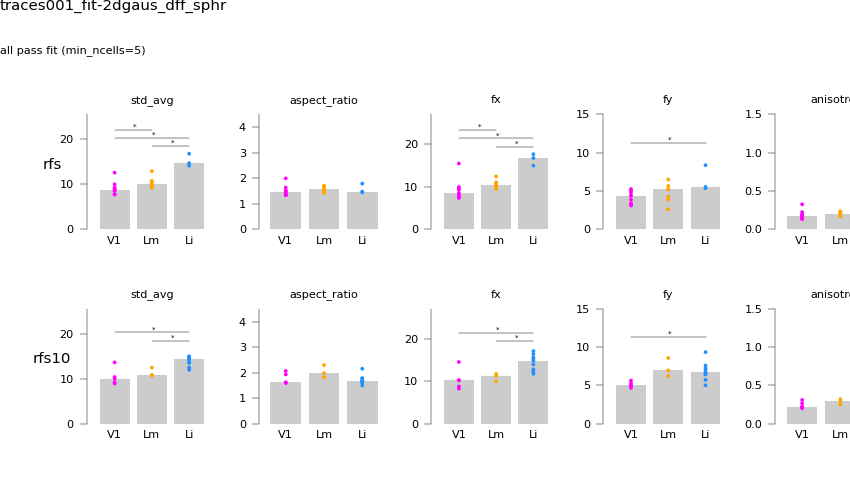

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs size_metrics_byFOV


In [864]:
%matplotlib notebook
plot_str='byFOV'
compare_fovdf = rfdata_u.groupby(['visual_area', 'datakey', 'experiment']).mean()\
                    .reset_index()
offset=1
plot_metrics = ['std_avg', 'aspect_ratio', 'fx', 'fy', 'anisotropy']
multi_comp_test='fdr_bh'
markersize=1
mean_type='median'
ylim = (0, 30)
fig, axn = pl.subplots(2, len(plot_metrics),
                       figsize=(7,4), sharey=False, dpi=150)
for ai, metric in enumerate(plot_metrics):
    maxv = compare_fovdf[metric].max()
    ylim = (0, np.ceil(maxv)*1.5)
    y_loc = maxv+(maxv/10.)
    offset = y_loc/10
    for ri, (rfsize, df_) in enumerate(compare_fovdf.groupby(['experiment'])):
        ax=axn[ri, ai]
        pplot.stripplot_metric_by_area(df_, metric, area_colors=area_colors,
                                markersize=2, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=y_loc/10.,
                                mean_style='bar', mean_type=mean_type, 
                                aspect=1., axis_offset=4)
        #ax.set_ylabel('deg. visual angle')
        ax.set_title(metric, fontsize=fontsize)
        if ai==0:
            ax.set_ylabel(rfsize, fontsize=8, rotation=0)
        else:
            ax.set_ylabel('')
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)
pplot.label_figure(fig, data_id)

fig.text(0, 0.9, 'Aggregate metrics, combined rfs (%s, min_ncells=%i)' \
         % (reliable_str, min_ncells) if reliable_only \
         else 'all pass fit (min_ncells=%i)' % min_ncells)
figname = 'size_metrics%s_%s' % (reliable_str, plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [797]:
for par in plot_metrics:
    print('%s ------------------------' % par)
    print(compare_fovdf.groupby(['visual_area', 'experiment'])[par].describe().round(2))


std_avg ------------------------
                        count   mean   std    min    25%    50%    75%    max
visual_area experiment                                                       
Li          rfs           3.0  15.17  1.41  14.08  14.38  14.68  15.72  16.76
            rfs10         9.0  13.92  1.10  11.95  13.47  14.34  14.76  14.94
Lm          rfs           7.0  10.37  1.22   9.17   9.72  10.01  10.53  12.89
            rfs10         3.0  11.32  0.98  10.68  10.76  10.83  11.64  12.44
V1          rfs           9.0   9.14  1.46   7.71   8.47   8.76   9.19  12.56
            rfs10         5.0  10.38  1.89   8.91   9.13   9.95  10.34  13.60
aspect_ratio ------------------------
                        count  mean   std   min   25%   50%   75%   max
visual_area experiment                                                 
Li          rfs           3.0  1.57  0.19  1.45  1.46  1.47  1.63  1.78
            rfs10         9.0  1.71  0.19  1.49  1.63  1.66  1.77  2.15
Lm          rfs  

#### Look at THETA specifically

In [724]:
cells_w_both['theta'].max()

6.282272560700279

<IPython.core.display.Javascript object>


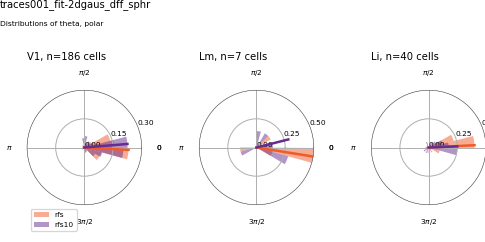

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/rfs5_v_rfs10 theta_hist__cells_w_both


In [723]:
bin_size = 15
bins=50
ai = 1
#ecolors=rf_colors['rfs', rf_colors['rfs10']] #['r', 'b']

fig = pl.figure(figsize=(6,3))
for va, vg in cells_w_both.groupby(['visual_area']):
    ai = visual_areas.index(va)
    polar_ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    for exp, eg in vg.groupby(['experiment']):
        ecol = rf_colors[exp]
        thetas = eg['theta'].values
        cmean = spstats.circmean(eg['theta'].values)
        degrees = np.array([np.rad2deg(v) for v in thetas])
        weights = np.ones_like(degrees)/len(degrees)
        a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size),
                            weights=weights)
        centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
        polar_ax.bar(centers, a, width=np.deg2rad(bin_size), 
                       bottom=0.0, color=ecol, edgecolor='none',
                    label=exp, alpha=0.5)
        polar_ax.plot([0, cmean], [0, max(a)], color=ecol, lw=2)
        # Label angles according to convention
        maxy=0.3 if va=='V1' else 0.5
        polar_ax.set_yticks(np.linspace(0, maxy, 3))
        polar_ax.set_ylim([0, maxy])
        polar_ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
        polar_ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'])
        polar_ax.set_title('%s, n=%i cells' % (va, len(eg)), loc='left', fontsize=8)
polar_ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.9, bottom=0.2, top=0.7, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.9, 'Distributions of theta, polar')

pplot.label_figure(fig, data_id)
figname = 'theta_hist__cells_w_both'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

# Combine them meh?

In [417]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [865]:
# combined_rfs = rfutils.average_rfs_select(rfdata)
reliable_only=False
reliable_str = '_reliable' if reliable_only else ''
avgrfs = rfutils.aggregate_fits(CELLS, meta,
                        response_type=response_type,
                        do_spherical_correction=do_spherical_correction,
                        reliable_only=reliable_only, 
                        pass_criterion=['position', 'size'], 
                        combine='select', ecc_center=(0, 20))

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [866]:
avgrfs.groupby(['visual_area', 'experiment']).count()

,,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,minor_axis,anisotropy,theta_Mm_c,aniso_index,eccentricity,eccentricity_ctr,rf_theta_deg,aspect_ratio,cell,datakey
visual_area,experiment,,,,,,,,,,,,,,,,,,,,,
Li,rfs10,491,491,491,491,491,491,491,491,491,491,...,491,491,491,491,491,491,491,491,491,491
Lm,rfs,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
V1,rfs,631,631,631,631,631,631,631,631,631,631,...,631,631,631,631,631,631,631,631,631,631


# Aggr metrics

#### Drop repeats

In [867]:
rf_type='combinedrfs'
min_ncells=5
aggr_counts = aggr.count_n_cells(avgrfs)
# aggr_counts = avgrfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
#                 .groupby(['visual_area', 'datakey']).count().reset_index()

# Only include rf-5 ----------------------------------------------
u_dkeys = aggr.drop_repeats(aggr_counts[aggr_counts.n_cells>=min_ncells].copy(),
                           colname='n_cells')
# best_ = p3.select_best_fovs(aggr_counts, criterion='max')
# final_rf_keys = list((va, dk) for (va, dk) in \
#                      best_[['visual_area', 'datakey']].values)
# Check with examples (rf-5):
# ('Lm', '20190506_JC080_fov1') OR ('Lm', '20190603_JC080_fov1')
# ('Lm', '20190506_JC080_fov1') in rf5_keys
# ('Lm', '20190603_JC080_fov1') in rf5_keys #best_rf5[['visual_area', 'datakey']].values

In [868]:
finaldf = pd.concat([rfs_ for (va, dk), rfs_ \
                     in avgrfs.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in all_rf_ukeys]) #u_dkeys])
finaldf.groupby(['visual_area']).count()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,anisotropy,theta_Mm_c,aniso_index,eccentricity,eccentricity_ctr,rf_theta_deg,aspect_ratio,cell,datakey,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,324,324,324,324,324,324,324,324,324,324,...,324,324,324,324,324,324,324,324,324,324
Lm,223,223,223,223,223,223,223,223,223,223,...,223,223,223,223,223,223,223,223,223,223
V1,545,545,545,545,545,545,545,545,545,545,...,545,545,545,545,545,545,545,545,545,545


In [869]:
# rfdata_u
finaldf = rfutils.combine_rfs_select(rfdata_u)
finaldf.groupby(['visual_area']).count()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,324,324,324,324,324,324,324,324,324,324,...,324,324,324,324,324,324,324,324,324,324
Lm,223,223,223,223,223,223,223,223,223,223,...,223,223,223,223,223,223,223,223,223,223
V1,545,545,545,545,545,545,545,545,545,545,...,545,545,545,545,545,545,545,545,545,545


In [870]:
#### Current output dir
curr_dst_dir = os.path.join(dst_dir,  'combined_rfs')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs


In [871]:
final_counts = finaldf.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,324
Lm,223
V1,545


In [872]:
counts_outfile = os.path.join(curr_dst_dir, 'final_counts%s.csv' % reliable_str)
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs/final_counts.csv


In [873]:
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,324
Lm,223
V1,545


In [874]:
final_counts = hutils.split_datakey(final_counts)
final_counts.groupby(['visual_area'])['animalid'].count()

visual_area
Li    9
Lm    7
V1    9
Name: animalid, dtype: int64

In [875]:
print("Avg N cells fit (single RFs):")
print(final_counts.groupby('visual_area').describe().round(2))

Avg N cells fit (single RFs):
             cell                                             
            count   mean    std   min   25%   50%   75%    max
visual_area                                                   
Li            9.0  36.00  24.12   6.0  14.0  30.0  56.0   72.0
Lm            7.0  31.86  23.30   7.0  10.0  34.0  49.0   64.0
V1            9.0  60.56  39.16  11.0  27.0  57.0  91.0  125.0


In [876]:
%matplotlib notebook

<IPython.core.display.Javascript object>


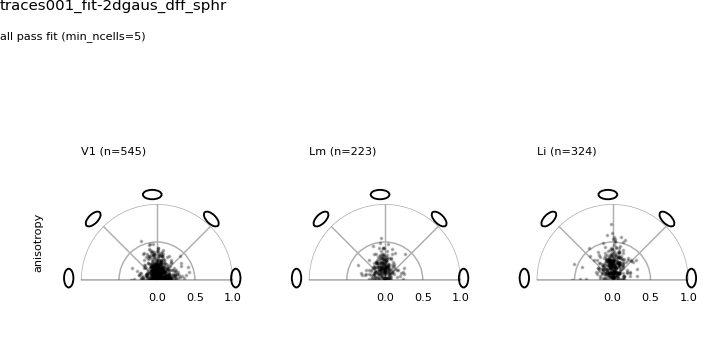

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])


Saved: anisotropy_bw
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/single_cell_aggregate/receptive_fields/sphr_corrected


In [877]:
%matplotlib notebook
markersize=1
alpha=1
fontsize=6

cmap='spring_r'
metric='anisotropy'
rf_names = np.arange(-90, 90+45, 45)
rf_color='k'
ell_icon_height = 5

fig, axn = pl.subplots(1, 3, subplot_kw=dict(projection='polar'), 
                       figsize=(6,3), dpi=150)
for va, vg in finaldf.groupby(['visual_area']):
    ai= visual_areas.index(va)
    ax = axn[ai]
    #ax = fig.add_subplot(2, 3, ai+3+1, projection="polar")
    thetas = vg['theta_Mm_c'].values #% np.pi # all thetas should point the same way
    ratios = vg['anisotropy'].values
    ax.scatter(thetas, ratios, marker='o', s=markersize, alpha=0.25,
               c='k', zorder=10000) #c=area_colors[va])
    pplot.adjust_polar_axes(ax)
    if ai!=0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('anisotropy', fontsize=fontsize, labelpad=20)
        #ax.set_xlabel('theta', fontsize=fontsize, labelpad=0)
    ax.set_title('%s (n=%i)' % (va, len(vg)), fontsize=6, loc='left')
    # ticks
    #ax.set_yticklabels([])
for ax in axn.flat:
    ylim = np.ceil(finaldf['anisotropy'].max()) #0.57
    ytick_lim = np.floor(ylim*10)/10.
    ax.set_ylim([0, ylim])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    ax.set_yticks(np.linspace(0, ytick_lim, 3))
    ax.set_yticklabels(np.linspace(0, ytick_lim, 3))

    ax.set_xlabel('')
    ax.set_theta_zero_location("N")
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))

pl.subplots_adjust(top=0.7, left=0.1, right=0.85, bottom=0.1, wspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Anisotropy, combined rfs (%s), min_ncells=%i' \
                     % (reliable_str, min_ncells) if reliable_only \
         else 'all pass fit (min_ncells=%i)' % min_ncells)
figname = 'anisotropy_bw%s' % reliable_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print("Saved: %s" % figname)
print(curr_dst_dir)
print(FIGDIR)


In [878]:
plot_metrics = ['std_avg', 'fx', 'fy', 'aspect_ratio']
pplot.print_means(finaldf, groupby=['visual_area'], params=plot_metrics,
                 metric='median')

[median]:
  visual_area    std_avg         fx        fy  aspect_ratio  std_avg_std  \
0          Li  13.350799  13.997368  5.179229      1.555549     3.649796   
1          Lm  10.458955  10.738420  4.277639      1.438731     3.430516   
2          V1   8.328126   8.474969  3.226925      1.352159     2.302751   

     fx_std    fy_std  aspect_ratio_std  
0  6.281735  5.193129          0.591430  
1  4.668985  4.495833          0.370165  
2  3.638665  3.242689          0.330834  


In [879]:
finaldf.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy',
       'theta_c', 'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy',
       'theta_Mm_c', 'aniso_index', 'eccentricity', 'eccentricity_ctr',
       'rf_theta_deg', 'aspect_ratio', 'cell', 'datakey', 'visual_area',
       'experiment', 'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix',
       'fov_ypos', 'fov_ypos_pix', 'ml_pos', 'ap_pos'],
      dtype='object')

<IPython.core.display.Javascript object>


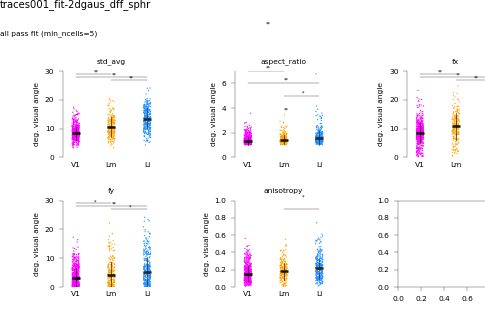

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs size_metrics_byCELL


In [880]:
%matplotlib notebook
plot_str='byCELL'
offset=1
plot_metrics = ['std_avg', 'aspect_ratio', 'fx', 'fy', 'anisotropy']
multi_comp_test='fdr_bh'
markersize=1
mean_type='median'
ylim = (0, 30)
fig, axn = pl.subplots(2, int(np.ceil(len(plot_metrics)/2)),
                       figsize=(6,4), sharey=False)
for ai, (ax, metric) in enumerate(zip( axn.flat, plot_metrics)):
    if metric=='aspect_ratio':
        ylim = (0, 7)
        y_loc=5
    elif metric=='anisotropy':
        ylim = (0, 1)
        y_loc=0.9
    else:
        y_loc=27
        ylim = (0, 30)
    pplot.stripplot_metric_by_area(finaldf, metric, area_colors=area_colors,
                                markersize=1, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, 
                                plot_means=True, y_loc=y_loc, offset=offset,
                                mean_style='point', mean_type=mean_type, 
                                aspect=1., axis_offset=4)
    ax.set_ylabel('deg. visual angle')
    ax.set_title(metric, fontsize=fontsize)
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)
pplot.label_figure(fig, data_id)

fig.text(0, 0.9, 'Aggregate metrics, combined rfs (%s), min_ncells=%i' \
         % (reliable_str, min_ncells) if reliable_only \
         else 'all pass fit (min_ncells=%i)' %  min_ncells)
figname = 'size_metrics%s_%s' % (reliable_str, plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [882]:

min_ncells=5
fits_pass_ncells_count = final_counts[final_counts.cell>=min_ncells].copy()
fits_pass = pd.concat([finaldf[(finaldf.visual_area==va) & (finaldf.datakey==dk)]\
                for (va, dk), g \
                in fits_pass_ncells_count.groupby(['visual_area', 'datakey'])])

fov_df = fits_pass.groupby(['visual_area', 'datakey']).mean().reset_index()

In [883]:
fov_df['fx'].max()

17.058297194173573

<IPython.core.display.Javascript object>


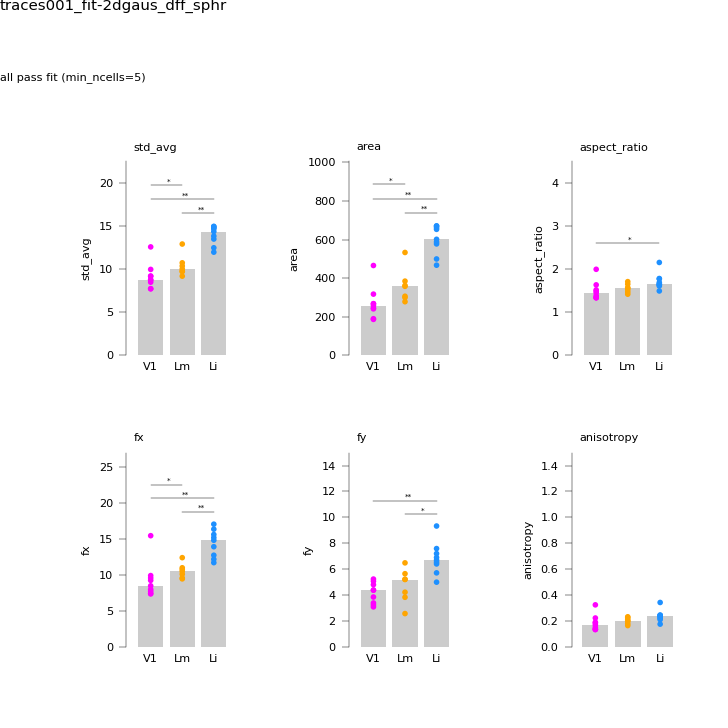

Saved: size_metrics_byFOV
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/single_cell_aggregate/receptive_fields/sphr_corrected
std_avg ---------------------
             count   mean   std    min    25%    50%    75%    max
visual_area                                                       
Li             9.0  13.92  1.10  11.95  13.47  14.34  14.76  14.94
Lm             7.0  10.37  1.22   9.17   9.72  10.01  10.53  12.89
V1             9.0   9.14  1.46   7.71   8.47   8.76   9.19  12.56
area ---------------------
             count    mean    std     min     25%     50%     75%     max
visual_area                                                              
Li             9.0  598.39  74.84  467.00  577.20  601.10  661.15  670.57
Lm             7.0  360.10  85.43  277.99  302.88  357.62  373.21  532.92
V1             9.0  270.98  83.22  186.54  240.99  258.19  268.00  465.

In [901]:
plot_str='byFOV'
plot_metrics = ['std_avg', 'area', 'aspect_ratio', 'fx', 'fy', 'anisotropy']
offset=0.5
multi_comp_test='fdr_bh'
markersize=1
mean_type='median'
stats_list = []
# fov_df = finaldf.groupby(['visual_area', 'datakey', 'experiment'])\
#                 .median().reset_index()
fig, axn = pl.subplots(2, int(np.ceil(len(plot_metrics)/2)),
                       figsize=(6,6), sharey=False, dpi=150)
for ai, (ax, metric) in enumerate(zip( axn.flat, plot_metrics)):
    maxv = fov_df[metric].max()
    ylim = (0, np.ceil(maxv)*1.5)
    y_loc = maxv+(maxv/10.)
    offset = y_loc/10
    ax, st = pplot.stripplot_metric_by_area(fov_df, metric, area_colors=area_colors,
                                markersize=3, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=offset,
                                mean_style='bar', mean_type=mean_type, 
                                aspect=2, axis_offset=4, return_stats=True)
    st['metric'] = metric
    stats_list.append(st)
    #ax.set_ylabel('deg. visual angle')
    ax.set_title(metric, fontsize=fontsize, loc='left')
fov_stats = pd.concat(stats_list, axis=0)
pl.subplots_adjust(top=0.8, left=0.1, right=0.9, bottom=0.2, wspace=0.1, hspace=0.5)
fig.text(0, 0.9, 'Aggregate metrics, combined rfs (%s), min_ncells=%i' \
         % (reliable_str, min_ncells) if reliable_only \
         else 'all pass fit (min_ncells=%i)' % min_ncells)

pplot.label_figure(fig, data_id)
figname = 'size_metrics%s_%s' % (reliable_str,  plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print('Saved: %s' % figname)
print(curr_dst_dir)
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR)

for par in plot_metrics:
    print("%s ---------------------" % par)
    print(fov_df.groupby('visual_area')[par].describe().round(2))

In [927]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr'

In [903]:
for va, vg in fits_pass.groupby(['visual_area']):
    dkey_lut = dict((v, k) for k, v in enumerate(vg['datakey'].unique()))
    fits_pass.loc[vg.index, 'site_num']= [dkey_lut[k] for k in vg['datakey'].values]

<IPython.core.display.Javascript object>


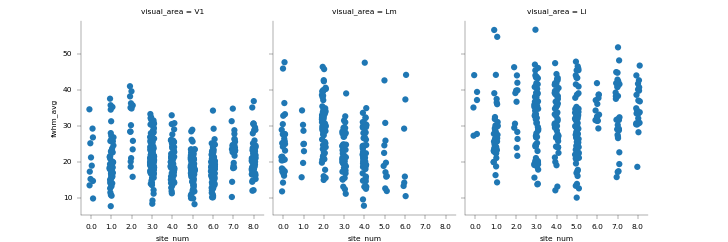

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [904]:
fg = sns.FacetGrid(data=fits_pass, col='visual_area', col_order=visual_areas,
                  height=3)
fg.map(sns.stripplot, 'site_num', 'fwhm_avg')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)

## Average population RF size

In [905]:
import analyze2p.objects.sim_utils as su

from shapely.geometry import MultiPolygon
#import geopandas as gpd
from shapely.ops import unary_union
# from shapely.ops import cascaded_union 

In [906]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [907]:
# Get polygons
#try:
#    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
#except FileNotFoundError as e:
rfpolys, check_rfs = su.update_rfpolys(avgrfs, rf_fit_desc, create_new=True,
                                       save=False, limit_screen=False,
                                      combine_method='select')
    

    adding 20190430_JC078_fov1, 34
    adding 20190501_JC076_fov1, 11
    adding 20190504_JC078_fov1, 9
    adding 20190506_JC080_fov1, 37
    adding 20190507_JC083_fov1, 54
    adding 20190508_JC083_fov1, 80
    adding 20190509_JC078_fov1, 7
    adding 20190510_JC083_fov1, 28
    adding 20190511_JC083_fov1, 42
    adding 20190512_JC083_fov1, 56
    adding 20190513_JC078_fov1, 19
    adding 20190517_JC083_fov1, 21
    adding 20190522_JC084_fov1, 125
    adding 20190522_JC089_fov1, 6
    adding 20190525_JC084_fov1, 44
    adding 20190527_JC092_fov3, 45
    adding 20190528_JC092_fov1, 13
    adding 20190602_JC091_fov1, 64
    adding 20190603_JC080_fov1, 54
    adding 20190606_JC091_fov1, 38
    adding 20190607_JC091_fov1, 57
    adding 20190609_JC099_fov1, 43
    adding 20190612_JC099_fov1, 56
    adding 20190613_JC097_fov1, 64
    adding 20190614_JC091_fov1, 72
    adding 20190616_JC097_fov1, 100
    adding 20190617_JC097_fov1, 91
    adding 20190617_JC099_fov1, 14
    adding 20190618_J

In [928]:
pix_per_deg = 16.05
conversion_factor = pix_per_deg**2

In [929]:
p_list = []
for (va, dk), g in finaldf.groupby(['visual_area', 'datakey']):
    curr_polys = rfpolys[(rfpolys.datakey==dk) 
                         & (rfpolys['cell'].isin(g['cell'].unique()))].copy()
    curr_polys['visual_area'] = va
    p_list.append(curr_polys)
poly_df = pd.concat(p_list, axis=0, ignore_index=True)

In [930]:
poly_df.shape, finaldf.shape

((1092, 4), (1092, 40))

In [931]:
combined_df = pd.merge(finaldf, poly_df, on=['visual_area', 'datakey', 'cell'], 
                       how='outer')
combined_df['poly_area'] = [c.area for c in combined_df['poly'].values]

combined_df['poly_area_deg'] = combined_df['poly_area']/conversion_factor

combined_df['fwhm_area'] = np.pi*(combined_df['fwhm_x']/2. * combined_df['fwhm_y']/2.)

In [932]:
combined_df.loc[combined_df.fwhm_area < combined_df.poly_area_deg][['fwhm_area', 'poly_area_deg']]

,fwhm_area,poly_area_deg


<IPython.core.display.Javascript object>


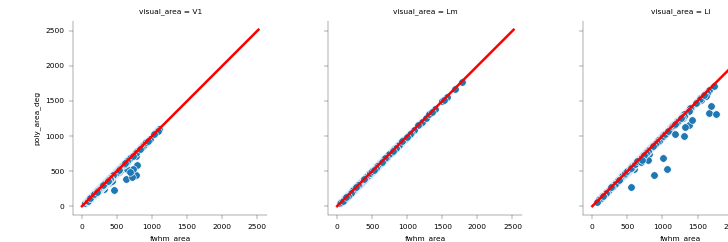

In [933]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=combined_df)
fg.map(sns.scatterplot, 'fwhm_area', 'poly_area_deg')
pl.subplots_adjust(bottom=0.2)
maxv = combined_df[['fwhm_area', 'poly_area_deg']].max().max()
for ax in fg.fig.axes:
    ax.set_aspect('equal')
    ax.plot([0, maxv], [0, maxv], 'r', lw=2)

In [935]:
x = np.where(combined_df.fwhm_area > combined_df.poly_area_deg)
x

(array([   0,    1,    2, ..., 1089, 1090, 1091]),)

In [936]:
combined_df.iloc[x][['fwhm_area', 'poly_area_deg']]

,fwhm_area,poly_area_deg
0,1358.292668,1354.389030
1,588.709999,585.790122
2,825.693059,822.503664
3,1187.811621,1182.775788
4,549.310395,544.777322
...,...,...
1087,614.345964,612.342660
1088,371.570747,369.825603
1089,210.582175,208.600460
1090,304.158654,301.821605


In [937]:
p_list=[]
for (va, dk), curr_polys in poly_df.groupby(['visual_area', 'datakey']):
    poly_list = [p for p in curr_polys['poly'].values]
#     intersection = cascaded_union(
#     [a.intersection(b) for a, b in itertools.combinations(poly_list, 2)]
#     )
    union_rfs = unary_union(poly_list)
    p_list.append(pd.Series({'visual_area': va, 'datakey': dk, 
                            'poly': union_rfs, 'area': union_rfs.area}))
merged = pd.concat(p_list, axis=1, ignore_index=True).T

In [938]:
merged['area'] = merged['area'].astype(float)
merged['area_deg'] = merged['area'].astype(float)/conversion_factor

In [939]:
screen = hutils.get_screen_dims()
screen

{'azimuth_deg': 119.5564,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'altitude_cm': 58.0,
 'resolution': [1920, 1080],
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106)}

In [940]:
#screen_area = screen['azimuth_deg'] * screen['altitude_deg']
# screen_area = screen['resolution'][0] * screen['resolution'][1]
#merged['fraction_total_area'] = merged['area']/screen_area

<IPython.core.display.Javascript object>


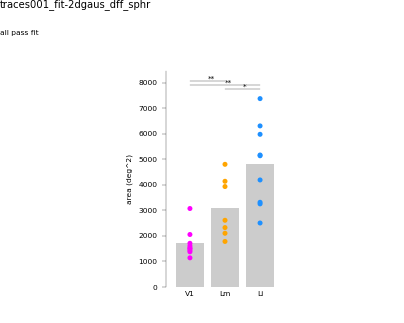

             count    mean     std     min     25%     50%     75%     max
visual_area                                                               
Li             9.0  4809.1  1612.8  2508.5  3320.2  5143.8  5984.6  7383.5
Lm             7.0  3103.7  1172.9  1786.2  2217.3  2614.9  4040.7  4808.5
V1             9.0  1716.7   567.4  1143.6  1438.9  1527.0  1713.4  3076.2
Saved: pRF_area_deg__byFOV
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/single_cell_aggregate/receptive_fields/sphr_corrected


In [943]:
metric='area_deg' #'fraction_total_area'
fig, ax = pl.subplots()
max_v = merged[metric].max()
y_loc = max_v*1.05
ax, st = pplot.stripplot_metric_by_area(merged, metric, area_colors=area_colors,
                            markersize=4, ylim=None, ax=ax,
                            sig_fontsize=6, jitter=False, 
                            plot_means=True, y_loc=y_loc, offset=y_loc/50.,
                            mean_style='bar', mean_type='mean', 
                            aspect=2, axis_offset=4, return_stats=True)
# ax.set_ylim([0, 1])
ax.set_ylabel('area (deg^2)')
fig.text(0, 0.9, 'populationRF, combined rfs (%s)' \
         % reliable_str if reliable_only else 'all pass fit')

print(merged.groupby(['visual_area'])[metric].describe().round(1))

pplot.label_figure(fig, data_id)
figname = 'pRF_%s_%s_%s' % (metric, reliable_str,  plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print('Saved: %s' % figname)
print(curr_dst_dir)
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR)

In [942]:
st

,Contrast,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,eta-square
0,visual_area,Li,Lm,False,False,52.0,two-sided,0.034258,0.034258,fdr_bh,0.259390
1,visual_area,Li,V1,False,False,80.0,two-sided,0.000574,0.001721,fdr_bh,0.620591
2,visual_area,Lm,V1,False,False,58.0,two-sided,0.005921,0.008881,fdr_bh,0.383368


#### Plot overlays

<IPython.core.display.Javascript object>


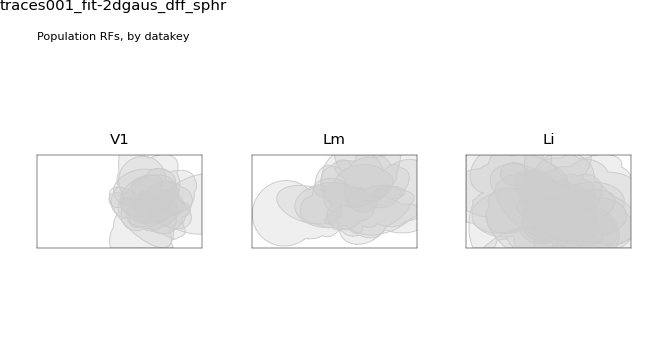

/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/single_cell_aggregate/receptive_fields/sphr_corrected


In [926]:
pRF_alpha=0.3
pRF_lw = 0.5
pRF_color = [0.8]*3
fill_poly=True
fig, axn = pl.subplots(1,3, figsize=(5.5,3), dpi=150)
for (va, dk), poly_ in merged.groupby(['visual_area', 'datakey']):
    ax = axn[visual_areas.index(va)]
    pRF = poly_['poly'].iloc[0]
    if not isinstance(pRF, MultiPolygon):
        ax.plot(*pRF.exterior.xy, color=pRF_color, lw=pRF_lw, alpha=1)
        if fill_poly:
            ax.fill(*pRF.exterior.xy, color=pRF_color, lw=0, alpha=pRF_alpha)
    else:
        for geom in pRF.geoms:
            ax.plot(*geom.exterior.xy, color=pRF_color, lw=pRF_lw, alpha=1)
            if fill_poly:
                ax.fill(*geom.exterior.xy, color=pRF_color, lw=pRF_lw,alpha=pRF_alpha)
    ax.set_title(va)
    pplot.turn_off_axis_ticks(ax, despine=False)
for ax in axn.flat:
    ax.set_xlim([0, screen['resolution'][0]])
    ax.set_ylim([0, screen['resolution'][1]])
    ax.set_aspect('equal')
pl.subplots_adjust(left=0.05, right=0.85, bottom=0.2, top=0.8, wspace=0.3)

pplot.label_figure(fig, data_id)

fig.text(0.05, 0.9, 'Population RFs, by datakey')

figname = 'pRFs_overlaid'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR)

In [647]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr'

#### Check that union matches overlay

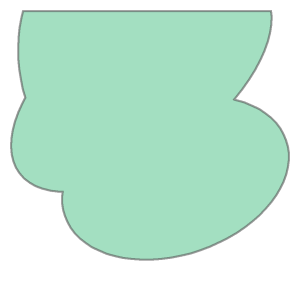

In [517]:
merged[merged.datakey=='20190522_JC089_fov1']['poly'][0]

In [518]:
p_list[0]

visual_area                                                   Li
datakey                                      20190522_JC089_fov1
poly           POLYGON ((1051 314, 1050 315, 1037 315, 1036 3...
area                                                    532273.0
dtype: object

In [519]:
va = p_list[0]['visual_area']
dk = p_list[0]['datakey']
curr_polys = poly_df[(poly_df.visual_area==va)
                     & (poly_df.datakey==dk)].copy()
poly_list = [p for p in curr_polys['poly'].values]

In [520]:
multi_polys = MultiPolygon(poly_list)
union2 = unary_union(poly_list)


<IPython.core.display.Javascript object>


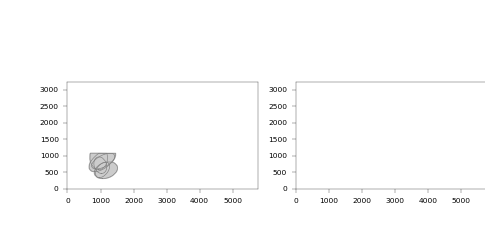

In [524]:
%matplotlib notebook
fig, axn = pl.subplots(1, 2, figsize=(6, 3))

multi_polys = MultiPolygon(poly_list)
ax=axn[0]
for ii, poly in enumerate(multi_polys):
    x,y = poly.exterior.xy
    ax.plot(x,y, color=[0.5]*3, lw=0.5)
aggr_poly_ = merged[merged.datakey=='20190527_JC092_fov3']['poly'].iloc[0]
# ax.plot(*aggr_poly_.exterior.xy, color='k', lw=2)
ax.fill(*union2.exterior.xy, color=[0.8]*3, lw=1)
for ax in axn.flat:
    ax.set_xlim([0, screen['resolution'][0]*3])
    ax.set_ylim([0, screen['resolution'][1]*3])
    ax.set_aspect('equal')

#### Overlap v. distance

In [78]:
# Calculate overlaps and distance (pairwise)
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
# Convert RF fit params to polygon
d_=[]
for (va, dk), rfs_ in finaldf.groupby(['visual_area', 'datakey']):
    rois_ = rfs_['cell'].unique()
    if (va, dk) not in final_rf_keys:
        continue      
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    rfs_.index = rfs_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[overlaps_['poly1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[overlaps_['poly2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    overlaps_['cortical_distance'] = dists
    overlaps_['visual_area'] = va
    overlaps_['datakey'] = dk
    d_.append(overlaps_)
overlaps = pd.concat(d_)
overlaps = overlaps.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})

In [79]:
overlaps[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts()

Li    12
V1     9
Lm     8
Name: visual_area, dtype: int64

In [80]:
overlaps.head()

,cell_1,cell_2,area_overlap,perc_overlap,cortical_distance,visual_area,datakey
0,116.0,121.0,0.452186,0.737842,59.145341,Li,20190522_JC089_fov1
0,116.0,122.0,0.476668,0.974101,80.706373,Li,20190522_JC089_fov1
0,116.0,130.0,0.599980,0.894683,272.596672,Li,20190522_JC089_fov1
0,116.0,145.0,0.559354,0.758723,139.574437,Li,20190522_JC089_fov1
0,116.0,146.0,0.405485,0.788676,346.653270,Li,20190522_JC089_fov1


In [81]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 8

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    overlaps['binned_dist'], bin_edges = pd.qcut(overlaps['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    overlaps['binned_dist'], bin_edges = pd.cut(overlaps['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

binning: eqwidth6


In [82]:
meanf = overlaps.groupby(['visual_area', 'datakey', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


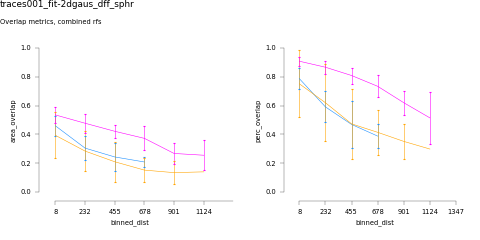

In [84]:
lw=0.5
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['area_overlap', 'perc_overlap']):
    sns.lineplot(x='binned_dist', y=metric, data=meanf, ax=ax,
                 hue='visual_area', palette=area_colors, 
                 ci='sd', err_style='bars',
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
    ax.set_xticks(list(range(len(bin_edges))))
    ax.set_xticklabels([round(i) for i in bin_edges])
    ax.set_ylim([0, 1])
    sns.despine(offset=8, trim=True, ax=ax)
    ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Overlap metrics, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'overlap_by_distance.svg'))

<IPython.core.display.Javascript object>


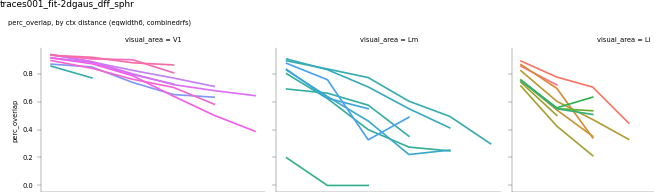

In [85]:
# fig, ax = pl.sublots()
metric = 'perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist' % (metric)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [87]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs'

# On screen

In [88]:
# Convert to degrees
screen = p3.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [89]:
import retino_utils as retutils

In [97]:
def get_retino_metadata(sdata, 
                    roi_type='pixels', traceid=None,
                    return_errors=False,
                    rootdir='/n/coxfs01/2p-data', 
                    aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    '''
    Gets analysis ID info for ROI-based retino analyses.
    '''
    meta_list=[]
    no_retino=[]
    errors=[]
    for (va, dk, animalid, session, fov), g in \
                sdata.groupby(['visual_area', 'datakey', 'animalid', 'session', 'fov']):
        exp_list = [e for e in g['experiment'].values if 'retino' in e] 
        if len(exp_list)==0:
            print('... skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
            continue
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov,\
                                        'retino_*', 'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retinorun = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                try:
                    rid_fpath = glob.glob(os.path.join(retino_dir, 
                                                       'analysisids_*.json'))[0]
                    with open(rid_fpath, 'r') as f:
                        retids = json.load(f)
                    retids = [r for r, res in retids.items() \
                                if res['PARAMS']['roi_type']==roi_type] 
                    assert len(retids)>0, "No ROI-based analyses"
                except AssertionError as e:
                    #print("ERROR")
                    no_retino.append(retino_dir)
                    continue
                except Exception as e:
                    print('ERROR', e)
                    no_retino.append(retino_dir)
                    continue
                for retid in retids: 
                    try:
                        fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                                    'retino_analysis', 'retino_structure', \
                                      'projections_%s.pkl' %  va)
                        assert os.path.exists(fpath), \
                            "No projection results (%s, %s, %s)" % (va, dk, retid)
                        meta_list.append(
                            tuple([va, animalid, session, fov, retinorun, retid, fpath]))
                    except Exception as e:
                        print(e)
                        errors.append((retino_dir, retid))
                        continue
            else:
                fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                        'retino_analysis', 'retino_structure', \
                                  'projections_%s.pkl' %  va)
                meta_list.append(
                    tuple([va, animalid, session, fov, retinorun, traceid, fpath]))
    retmeta = pd.DataFrame(meta_list, 
        columns=['visual_area', 'animalid', 'session', \
                 'fov', 'retino_run', 'analysis_id','proj_path'])
    if return_errors:
        return retmeta, no_retino, errors
    else:
        return retmeta

In [91]:
import retino_utils as retutils

In [92]:
#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)

pixels_thr-0.003


In [93]:
retmeta = pd.concat([g for (va, dk), g in sdata.groupby(['visual_area', 'datakey'])\
            if ('retino' in g['experiment'].values)])
ret_keys = list((va, dk) for (va, dk) in \
                retmeta[['visual_area', 'datakey']].drop_duplicates().values)

In [98]:
print("Threshold info: %s" % magthr_str)
retino_meta, no_ret, errs = get_retino_metadata(retmeta, roi_type='pixels',
                                                return_errors=True, traceid=None)
# retino_meta = get_projection_result_paths(retino_meta)
print("%i without ROI analysis" % len(no_ret))
for r in no_ret: print('... %s' % r)
print("%i ERR loading projection vectors" % len(errs))
for r in errs: print('... %s' % str(r))
retino_meta = p3.add_datakey(retino_meta)

Threshold info: pixels_thr-0.003
ERROR list index out of range
No projection results (Li, 20190327_JC073_fov1, analysis001)
No projection results (Li, 20190327_JC073_fov1, analysis001)
No projection results (Lm, 20190314_JC070_fov2, analysis001)
No projection results (Lm, 20190327_JC073_fov1, analysis001)
No projection results (Lm, 20190327_JC073_fov1, analysis001)
No projection results (Lm, 20190422_JC076_fov1, analysis001)
No projection results (V1, 20190508_JC083_fov1, analysis001)
1 without ROI analysis
... /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run2/retino_analysis
7 ERR loading projection vectors
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC070/20190314/FOV2_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_anal

In [99]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    return
import shutil
# Create dir to copy gradient images to, for visual inspection
copy_images = True
dst = os.path.join(curr_dst_dir, 'gradient_maps')
if not os.path.exists(dst):
    os.makedirs(dst)
if copy_images:
    delete_files(dst)
print(dst)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs/gradient_maps


In [100]:

def copy_gradient_maps(fpath, dst, prefix=None):
    src = os.path.split(fpath)[0]
    fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
    fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
    if len(fimpaths)==0:
        fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))
    for fimpath in fimpaths:
        fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
        fn = 'gradients' if 'gradients' in fname else 'unitvec'
        if prefix is None:
            new_fn = fname
        else:
            new_fn ='%s_%s%s' % (prefix, fn, fext)
        shutil.copyfile(fimpath, os.path.join(dst, new_fn))

In [101]:
d_list=[]
cols = ['visual_area', 'datakey', 'retino_run', 'analysis_id', 'proj_path']
for di, (va, dk, retinorun, retinoid, fpath) in enumerate(retino_meta[cols].values):
    if di % 20 == 0 or di==(len(retino_meta)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(retino_meta)))
    with open(fpath, 'rb') as f:
        res = pkl.load(f, encoding='latin1')
    tmpd = res['regr_df'].copy()
    metainfo = {'visual_area': va,  'datakey': dk, 
                'retinorun': retinorun, 'retinoid': retinoid, 'fpath':fpath}
    tmpd = p3.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)
    if copy_images:
        prefix= '%s_%s_%s' % (va, dk, retinorun)
        copy_gradient_maps(fpath, dst, prefix=None)
    
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)
projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

1 of 84 gradient result files loaded.
21 of 84 gradient result files loaded.
41 of 84 gradient result files loaded.
61 of 84 gradient result files loaded.
81 of 84 gradient result files loaded.
84 of 84 gradient result files loaded.


In [87]:
#     with open(fpath, 'rb') as f:
#         res = pkl.load(f, encoding='latin1')
#     tmpd = res['regr_df'].copy()
#     tmpd

In [88]:
#     src = os.path.split(fpath)[0]
#     fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
#     fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
#     if len(fimpaths)==0:
#         fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
#         fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))

In [89]:
# fimpaths

In [102]:
# Drop repeated retino run
best_retino = retutils.select_strongest_retinorun(projection_df)
best_retino['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun \
                            in best_retino[['datakey', 'retinorun']].values]
print(projection_df.shape, best_retino.shape)

(168, 14) (144, 15)


In [103]:
# Select FOVs with BOTH azimuth and elevation passed
retino_r2_thr=0.5
projdf = pd.concat([g for (varea, datakey, retinorun), g \
                in best_retino.groupby(['visual_area', 'datakey', 'retinorun']) \
                if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) \
                and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
print(best_retino.shape, projdf.shape)

(144, 15) (126, 15)


In [104]:
# Match retino + RF datasets
all_retino_keys = list([tuple(v) for v in projdf[['visual_area', 'datakey']]\
                    .drop_duplicates().values])
rf_df = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey'])\
                  if (va, dk) in all_retino_keys])

all_rf_keys = list([tuple(v) for v in rf_df[['visual_area', 'datakey']]\
                    .drop_duplicates().values])

# Select best RF by # cells (out of the retinos that pass)
final_counts = rf_df.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
print(len(all_rf_keys), len(all_retino_keys))
best_ = p3.select_best_fovs(final_counts, criterion='max')
final_rf_keys = list((va, dk) for (va, dk) in \
                     best_[['visual_area', 'datakey']].values)

41 63
[V1] Animalid does not exist: JC078 


In [105]:
final_dkeys = [k for k in all_retino_keys if k in final_rf_keys]
print(len(final_dkeys), len(final_rf_keys))

27 27


In [106]:
final_proj = pd.concat([g for (va, dk), g in projdf.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])
final_rfs = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])


In [107]:
final_proj[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,11
Lm,7
V1,9


In [108]:
retinodf = pd.concat([ret_ for (va, dk), ret_ in projdf.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in final_rf_keys])

In [109]:
retinodf[['visual_area', 'datakey', 'retinorun']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey,retinorun
visual_area,,
Li,11,11
Lm,7,7
V1,9,9


In [110]:
finaldf[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,12
Lm,8
V1,9


In [424]:
# final_rfs = aggdf.copy()
# final_proj = retinodf.copy()

In [111]:
def add_transformed_positions(final_rfs, final_proj):
    '''
    Load projection vectors (vectors_VA.pkl) provided by final_proj.
    Apply transform to ROI positions, 
    i.e., convert [ap_pos, ml_pos] --> [ml_proj, ap_proj]
    '''
    f0 = final_rfs.copy()
    f0['ml_proj'] = None
    f0['ap_proj'] = None
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area', 'datakey']):
        ret_ = final_proj[(final_proj['visual_area']==va) 
                        & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("... no pass retino: (%s, %s)" % (va, dk))
            continue
        # Get gradient_results path (vectors_VA.pkl) and load projection vectors
        assert len(ret_['fpath'].unique())==1, "[%s] Found retino path found: %s" \
                                            % (dk, str(ret_['fpath'].unique()))
        fpath = ret_['fpath'].unique()[0]
        gpaths = glob.glob(os.path.join(os.path.split(fpath)[0],
                                        'vectors_%s.pkl' % va))
        gpaths = [f for f in gpaths if '_pixels_thr' not in f] 
        assert len(gpaths)==1, "[%s, %s] Found retino path found: %s" \
                                                    % (dk, exp, str(gpaths))
        with open(gpaths[0], 'rb') as f:
            gresults = pkl.load(f, encoding='latin1')
        # Project FOV coordinates
        f0.loc[rfs_.index, 'ml_proj'] =np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
        f0.loc[rfs_.index, 'ap_proj'] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
    return f0
    

In [112]:
def filter_gradient_fits(final_proj, pass_crit='both', fit_thr=0.5):
    '''
    Filter gradient fits (projections) for retino data.
    '''
    if pass_crit=='both':
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    and (g[g['cond']=='el']['R2'].values>fit_thr))])
    else:
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    or (g[g['cond']=='el']['R2'].values>fit_thr))])
    return filtproj

In [113]:
def calculate_scatter_metrics_split_exp(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (visual_area, datakey, rfname), rfs_ in \
                final_rfs.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:    
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, datakey))
            not_enough_cells_fit.append(datakey)
            continue
        if datakey not in curr_gradients['datakey'].unique():
            print("--- bad gradient, %s" % datakey)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==visual_area) 
                            & (final_proj['datakey']==datakey)].copy()
        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)

            if any(np.isnan(dist_sc)):
                print(visual_area, datakey, r2)
                break
            if any(np.isnan(deg_sc)):
                print(visual_area, datakey, r2, deg_sc)
                break
            tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                               'deg_scatter': deg_sc[keep_ixs],
                               'dist_scatter': dist_sc[keep_ixs],
                               'measured_rf': rf_locs[keep_ixs],
                               'predicted_rf': predicted_rf_locs[keep_ixs],
                               'measured_loc': proj_locs[keep_ixs],
                               'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                               'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                               'axis': [cond for _ in np.arange(0, n_pts)],
                               'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                               'datakey': [datakey for _ in np.arange(0, n_pts)],
                               'rfname': [rfname for _ in np.arange(0, n_pts)]
                         })
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def calculate_scatter_metrics(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area','datakey']):
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, dk))
            not_enough_cells_fit.append(dk)
            continue
        if dk not in final_proj['datakey'].unique():
            print("--- bad gradient, %s" % dk)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==va) 
                            & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("none:: %s" % dk)
        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            #print(va, dk, cond, proj_locs)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)
            tmpd=pd.DataFrame({
                       'cell': rf_cell_ids[keep_ixs],
                       'deg_scatter': deg_sc[keep_ixs],
                       'dist_scatter': dist_sc[keep_ixs],
                       'measured_rf': rf_locs[keep_ixs],
                       'predicted_rf': predicted_rf_locs[keep_ixs],
                       'measured_loc': proj_locs[keep_ixs],
                       'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope})
            tmpd['retino_R2'] = r2
            tmpd['axis'] = cond
            tmpd['visual_area'] = va
            tmpd['datakey'] = dk
            tmpd['rfname'] = 'combined'
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def combine_scatter_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='dist_scatter']
    sd1 = scatdf[all_cols].copy().rename(columns={'deg_scatter': 'scatter_val'})
    sd1['scatter_label'] = 'vf_deg'

    all_cols = [k for k in scatdf.columns if k!='deg_scatter']
    sd2 = scatdf[all_cols].copy().rename(columns={'dist_scatter': 'scatter_val'})
    sd2['scatter_label'] = 'ctx_dist'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd


In [114]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.75
retino_pass_crit='both' 
final_rfs = add_transformed_positions(final_rfs, final_proj)
# Filter gradient data
curr_gradients = filter_gradient_fits(final_proj, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf = calculate_scatter_metrics(final_rfs, curr_gradients, min_ncells=5)
print(scatdf.shape)

sd = combine_scatter_metrics(scatdf)
mean_sc = sd.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- bad gradient, 20190607_JC091_fov1
--- bad gradient, 20190612_JC099_fov1
--- too few cells (min5), 20191012_JC113_fov1
--- bad gradient, 20190517_JC083_fov1
(1960, 12)


In [115]:
axis_palette={'az': [0.8]*3, 'el': [0.6]*3}

In [116]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.5
retino_pass_crit='both' 
all_rfs = add_transformed_positions(rf_df, projdf)
# Filter gradient data
all_gradients = filter_gradient_fits(projdf, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf_all = calculate_scatter_metrics(all_rfs, all_gradients, min_ncells=5)
print(scatdf_all.shape)
scat_comb_all = combine_scatter_metrics(scatdf_all)
mean_sc_all = scat_comb_all.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- too few cells (min5), 20191012_JC113_fov1
--- too few cells (min5), 20191111_JC120_fov1
--- too few cells (min5), 20190509_JC078_fov1
(2698, 12)


In [117]:
'20190616_JC097_fov1' in mean_sc_all['datakey'].values

True

In [118]:
s_=[]
for sc, mc in mean_sc.groupby(['scatter_label']):
    s0 = p3.paired_ttests(mc, metric='scatter_val', 
                        c1='az', c2='el', compare_var='axis', 
                        ttest=False)
    s0['scatter_label'] = sc
    s_.append(s0)
statdf = pd.concat(s_)
statdf

,t_stat,p_val,visual_area,scatter_label
0,15.0,0.742188,V1,ctx_dist
1,0.0,0.015625,Lm,ctx_dist
2,1.0,0.015625,Li,ctx_dist
0,1.0,0.015625,V1,vf_deg
1,3.0,0.078125,Lm,vf_deg
2,2.0,0.023438,Li,vf_deg


In [120]:
pplot.print_means(mean_sc, groupby=[ 'scatter_label', 'visual_area', 'axis'], 
                                  params=['scatter_val'])

[mean]:
   scatter_label visual_area axis  scatter_val  scatter_val_std
0       ctx_dist          Li   az    89.330822        46.068521
1       ctx_dist          Li   el   155.374899        51.918605
2       ctx_dist          Lm   az   129.241023        72.702387
3       ctx_dist          Lm   el   235.936680        51.034600
4       ctx_dist          V1   az   290.901882       112.401476
5       ctx_dist          V1   el   279.585408       110.859585
6         vf_deg          Li   az     7.364653         2.510264
7         vf_deg          Li   el     4.968918         1.339164
8         vf_deg          Lm   az     6.165601         2.074959
9         vf_deg          Lm   el     5.098930         1.806038
10        vf_deg          V1   az     5.299931         1.325770
11        vf_deg          V1   el     2.816061         0.552147


<IPython.core.display.Javascript object>


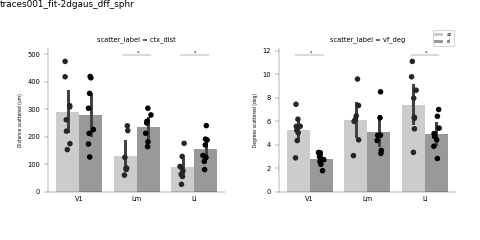

ctx_dist 497.8215667942389
vf_deg 11.66436134124201
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs scatter_dist_and_deg


In [121]:
fg = sns.FacetGrid(mean_sc, col='scatter_label', height=3, aspect=1,sharey=False)
fg.map(sns.barplot, 'visual_area', 'scatter_val', 'axis', 
       order=visual_areas, hue_order=['az', 'el'], palette=axis_palette)
fg.map(sns.stripplot, 'visual_area', 'scatter_val', 'axis', dodge=True, 
       order=visual_areas, hue_order=['az', 'el'], color='k')

bar_length=0.5
offset_frac = 0.25
fontsize=4
lw=0.25
for sl, g in statdf[statdf['p_val']<0.05].groupby(['scatter_label']):
    currax = fg.axes_dict[sl]
    yloc = currax.get_ylim()[-1]
    print(sl, yloc)
    offset = np.mean(np.diff(currax.get_yticks()))*offset_frac
    for va, gg in g.groupby(['visual_area']):
        vi = visual_areas.index(va)
        currax.plot( [vi-(bar_length/2.), vi+(bar_length/2.)], [yloc, yloc], 
                    color='k', lw=lw)
        star_str = '**' if float(gg['p_val'])<0.01 else '*'
        currax.text(vi, yloc, star_str, fontsize=fontsize)
    currax.tick_params(which='both', axis='x', size=0)
    currax.set_xlabel('')
    yl = 'Distance scattered (um)' if sl=='ctx_dist' else 'Degrees scattered (deg)'
    currax.set_ylabel(yl, fontsize=fontsize)
# Legend
fg.axes.flat[1].legend()
lh = pplot.crop_legend_labels(fg.axes.flat[1], n_hues=2, start_ix=2,
                            bbox_to_anchor=(1,1), loc='lower right', fontsize=fontsize)
pl.subplots_adjust(bottom=0.2, top=0.8, right=0.95, left=0.1, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'scatter_dist_and_deg'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [874]:
sc

'vf_deg'

In [863]:
d_=[]
for (sl, va), vg in mean_sc.groupby(['scatter_label', 'visual_area']):
    a_vals = vg[vg['axis']=='az']['scatter_val'].values
    b_vals = vg[vg['axis']=='el']['scatter_val'].values
    diffs = b_vals-a_vals
    df_ = pd.DataFrame({'el_minus_az': diffs})
    df_['visual_area'] = va
    df_['scatter_label'] = sl
    d_.append(df_)
diffs = pd.concat(d_)    

In [864]:
diffs['visual_area'] = diffs['visual_area'].astype('category')

<IPython.core.display.Javascript object>


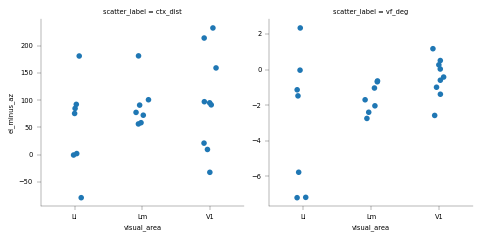

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [865]:

fg=sns.FacetGrid(diffs, col='scatter_label', height=3, sharey=False)
fg.map(sns.stripplot, 'visual_area', 'el_minus_az')

#### Scatter example

In [1568]:
va = 'V1'
dk = '20190522_JC084_fov1' #'20190617_JC097_fov1'
# dk = '20190616_JC097_fov1'

df_= scatdf_all[(scatdf_all.visual_area==va) & (scatdf_all.datakey==dk)].copy()
scatter_cols = ['cell', 'predicted_rf', 'measured_rf', 'predicted_loc', 'measured_loc']
df_[scatter_cols] = df_[scatter_cols].astype(float)


In [1569]:
df_.columns

Index(['cell', 'deg_scatter', 'dist_scatter', 'measured_rf', 'predicted_rf',
       'measured_loc', 'predicted_loc', 'retino_R2', 'axis', 'visual_area',
       'datakey', 'rfname'],
      dtype='object')

In [1573]:
nonnum = ['datakey', 'animalid', 'session', 'experiment', 'visual_area']
numcols = [k for k in final_rfs.columns if k not in nonnum]
final_rfs[numcols] = final_rfs[numcols].astype(float)

In [1574]:
rois_ = rfs_['cell'].unique()
rfs_ = final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_0= final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_.index=rfs_0['cell']
# Get retino gradient
ret_ = final_proj[(final_proj.visual_area==va) & (final_proj.datakey==dk)].copy()

In [1575]:
# Load boot results
session, animalid, fovn = p3.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn
eval_results, eval_params = rfutils.load_eval_results(
                                animalid, session, fov, experiment='rfs')
bootdata = eval_results['data']
boot_ = bootdata[bootdata['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]

<IPython.core.display.Javascript object>


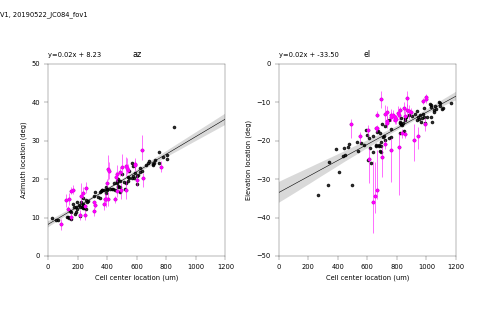

130
130
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs example_scatter_V1_20190522_JC084_fov1


In [1576]:
marker='o'
marker_size=5
ci = 0.95
lw=0.5
fill_marker=True
deviant_color='magenta'
scatter_kws={'s': marker_size, 'marker': marker}
line_kws={'lw': lw}

fig, axn = pl.subplots(1, 2, figsize=(6,4), sharex=True)

for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 50])
    else:
        ax.set_ylim([-50, 0])
    ax.set_xlim([0, 1200])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    # Get projected cortical position
    ax = rfutils.fit_with_deviants(boot_, cis_, rfs_, xname=xname, yname=yname, ax=ax,
                          scatter_kws=scatter_kws, line_kws=line_kws, 
                          deviant_color=deviant_color,lw=lw)
    ax.set_title(cond)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cell center location (um)')
    currd = df_[df_.axis==cond].copy()
    # should be equivalent to'measured_loc' and 'measured_rf' in SCATTERDF:
#     sns.scatterplot(x='measured_loc', y='measured_rf', data=currd, ax=ax,
#                    color='cyan', alpha=0.5)
        
fig.text(0, 0.95, '%s, %s' % (va, dk))
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'example_scatter_%s_%s' % (va, dk)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
